In [1]:
import torch
import glob
from miditoolkit.midi import parser as mid_parser  
from miditoolkit.midi import containers as ct
import numpy as np
import matplotlib.pyplot as plt

In [36]:
NUM_COMPRESS = 16
NUM_DURATIONS = 61
NUM_RESTS = 101
DURATION_SEQUENCE = [f"d{i}" for i in range(NUM_DURATIONS)]
REST_SEQUENCE = [f"r{i}" for i in range(NUM_RESTS)]
NOTE_SEQUENCE = [50, 52, 55, 57, 58, 59, 60, 62, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 76, 77, 79, 81]
NOTE_SEQUENCE = list(map(lambda pitch: f"n{pitch}", NOTE_SEQUENCE))
VOCABULARY = ["p", "s", "e"] + REST_SEQUENCE + NOTE_SEQUENCE + DURATION_SEQUENCE
LEN_VOCAB = len(VOCABULARY)

In [3]:
def load_midi_folder(path: str) -> list:
    list_path = glob.glob(path)
    midi_list = [mid_parser.MidiFile(_path) for _path in list_path]
    print(f"[INFO] Load successfully {len(midi_list)} file midi from source")
    list_path = list(map(lambda _path: _path.split("\\")[-1], list_path))
    return midi_list, list_path

In [37]:
def round_number(number: float) -> int:
    int_num = int(number)
    number -= int_num
    if number >= 0.5:
        return int_num + 1
    else:
        return int_num

In [38]:
def compress_duration(duration: list, compress_number: int) -> list:
    duration = list(map(lambda time: round_number(time/compress_number), duration))
    return duration

In [39]:
def midi2seq(midi_list: list) -> list:
    sequences = []
    tmp_cache = {
        "note": 0,
        "track": 0
    }
    for midi in midi_list:
        notes = midi.instruments[0].notes
        tmp_cache["track"] += (notes[-1].end//(2*midi.ticks_per_beat) + (notes[-1].end%(2*midi.ticks_per_beat) != 0))
        
        sub_pitch = 0
        if len(midi.key_signature_changes):
            sub_pitch = midi.key_signature_changes[0].key_number

        sequence = np.array(list(map(lambda note: [0, note.pitch-sub_pitch, note.end-note.start], notes)))
        rest_seq = np.array([0] + [notes[i].start-notes[i-1].end for i in range(1, len(notes))])
        rest_seq[rest_seq < 0] = 0
        sequence[::, 0] = rest_seq
        sequence = np.array(list(filter(lambda row: row[2]<=1000, sequence.tolist())))
        
        tmp_cache["note"] += len(notes)
        sequence[::, 0] = compress_duration(list(sequence[::, 0]), NUM_COMPRESS)
        sequence[::, 2] = compress_duration(list(sequence[::, 2]), NUM_COMPRESS)
        sequences.append(sequence.tolist())

    print("[INFO] Convert midi to sequences successfully")
    print(f"\t[+] Note: {tmp_cache['note']}")
    print(f"\t[+] Track: {tmp_cache['track']}")
    
    return sequences

In [40]:
def plot_midi_roll(midi: list) -> None:
    fig, ax = plt.subplots(figsize=(18, 5))
    ax.set_facecolor('White')
    start = np.zeros(len(NOTE_SEQUENCE))
    label = np.array(NOTE_SEQUENCE)
    
    for rest,pitch,duration in midi:
        start += rest
        width = np.zeros(len(NOTE_SEQUENCE))
        width[NOTE_SEQUENCE.index(f"n{pitch}")] = duration
        ax.barh(label, width, left=start, height=0.4, label=pitch, color="green")
        start += duration
    plt.xlabel("Time by tick")
    plt.ylabel("Pitch")
    plt.show()

In [41]:
def seq2vocab_idx(sequences: list) -> list:
    token_idx = []
    for seq in sequences:
        seq_idx = list(map(lambda row: [VOCABULARY.index(f"r{row[0]}"), VOCABULARY.index(f"n{row[1]}"), VOCABULARY.index(f"d{row[2]}")], seq))
        token_idx.append(seq_idx)
    return token_idx

In [42]:
def vocab_idx2tensor(tokens_idx: list) -> torch.Tensor:
    tensor_data = torch.Tensor()
    max_length = 0
    for idx, seq_idx in enumerate(tokens_idx):
        seq_idx = torch.tensor(seq_idx)
        seq_idx = torch.flatten(seq_idx)
        tokens_idx[idx] = seq_idx.view(1, len(seq_idx))
        max_length = max(max_length, len(seq_idx))
    
    for seq_idx in tokens_idx:
        pad_zeros = torch.zeros((1, max_length - seq_idx.size(1)))
        st_token = torch.tensor([[1]])
        en_token = torch.tensor([[2]])
        seq_idx = torch.cat([st_token, seq_idx, pad_zeros, en_token], dim=1)
        tensor_data = torch.cat((tensor_data, seq_idx), dim=0)
    return tensor_data

In [43]:
path = "./datasets/midi_songs/*.mid"
midi_list, list_path = load_midi_folder(path)
sequences = midi2seq(midi_list)

[INFO] Load successfully 34 file midi from source
[INFO] Convert midi to sequences successfully
	[+] Note: 3647
	[+] Track: 1174


In [44]:
[np.max(np.unique(np.array(sequences[i])[::, 2])) for i in range(len(sequences))]

[57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 28,
 57,
 60,
 57,
 57,
 60,
 57,
 60,
 57,
 60,
 60,
 60,
 30,
 60,
 60,
 60,
 57,
 60,
 60,
 60,
 57,
 28,
 57,
 60]

In [45]:
tokens_idx = seq2vocab_idx(sequences)
tensor_data = vocab_idx2tensor(tokens_idx)

In [46]:
torch.save(tensor_data, "./data_gen/data_v6.pt")

In [47]:
tensor_data.size()

torch.Size([34, 1085])

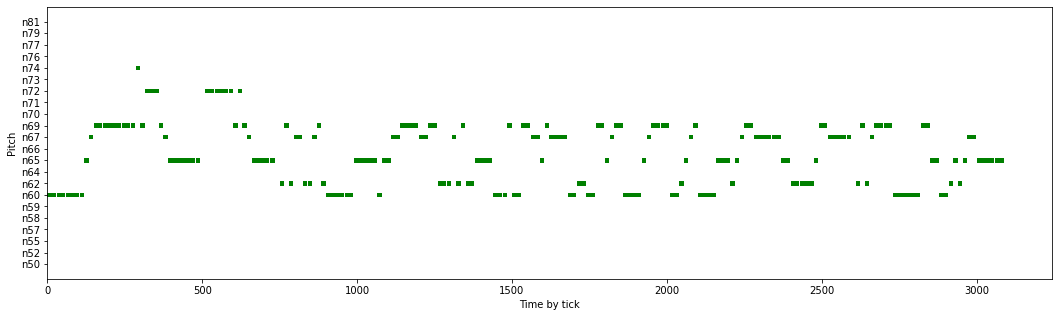

In [48]:
plot_midi_roll(sequences[2])

In [49]:
from train import NeuralNetwork
from model import Transformer

In [50]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
hyper_params = {
    "d_model": 1024,
    "n_layers": 6,
    "n_heads": 16,
    "d_ff": 512,
    "max_relative_dist": 2048,
    "max_position": 2048,
    "vocab_size": len(VOCABULARY),
    "dropout": 0.3,
    "norm_eps": 1e-3,
    "bias": True
}
data_path = "./data_gen/data_v6.pt"
cpk_path = "./checkpoints/model_v6.pt"
epoch = 10
batch_size = 1
pretrain = False

In [51]:
model = NeuralNetwork(
    hyper_params=hyper_params,
    data_path=data_path,
    batch_size=batch_size,
    check_point_path=cpk_path,
    warmup_steps=4000,
    test_size=0.3, 
    load_check_point=pretrain,
    device=device
)
model.fit(epoch)

Epoch:  1/10
	Train process:  ◒ |▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇| 100.0% 0.1s/step - Loss: 4.879 - Acc: 0.09 00m
	Valid process:  ◒ |▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇| 100.0% 0.03s/step - Loss: 1.35104 - Acc: 0.83 
=> Train loss: 5.24797 - Train acc: 0.02 - Valid loss: 2.08195 - Valid acc: 0.7  - Time: 3.88s/epoch
Epoch:  2/10
	Train process:  ◒ |▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇| 100.0% 0.1s/step - Loss: 2.75058 - Acc: 0.62 m
	Valid process:  ◒ |▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇| 100.0% 0.03s/step - Loss: 1.13412 - Acc: 0.91 
=> Train loss: 3.54105 - Train acc: 0.52 - Valid loss: 3.72744 - Valid acc: 0.7  - Time: 3.63s/epoch
Epoch:  3/10
	Train process:  ◒ |▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇| 100.0% 0.1s/step - Loss: 2.89534 - Acc: 0.52 m
	Valid process:  ◒ |▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇| 100.0% 0.03s/step - Loss: 2.7619 - Acc: 0.75 m
=> Train loss: 2.02316 - Train acc: 0.7 - Valid loss: 3.1805 - Valid acc: 0.7  - Time: 3.63s/epoch
Epoch:  4/10
	Train process:  ◒ |▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇| 1

In [52]:
def generate(model: Transformer, x: list) -> torch.Tensor:
    x = torch.tensor(x).to("cuda:0" if torch.cuda.is_available() else "cpu").long()
    x = x.unsqueeze(0)
    with torch.no_grad():
        while True:
            pred = model(x)
            k_top_pred = torch.topk(pred[0, -1, :], k=32, dim=0)
            pred_idx = torch.distributions.Categorical(logits=k_top_pred.values).sample()

            pred = k_top_pred.indices[pred_idx]
            if pred.item() == 2:
                break
            if x.size(1) > 1000:
                break
            x = torch.cat((x, pred.view(1, 1)), dim=1)
    return x.squeeze()[1:]

In [53]:
gen_data = generate(model.model, [1])

In [54]:
gen_data

tensor([  3, 133,   3, 117,   3, 111,   3, 134, 134,   3,   3, 124,   3, 134,
        134,   3, 134,   3, 134, 124,   3, 134, 111,   3, 134, 134,   3,   3,
        134, 124, 133,   3, 115, 134, 134, 134, 134,   3,   3, 134,   3,   3,
        134, 134,   3, 134,   3,   3, 117, 134, 141, 134, 134, 134,   3, 134,
        134,   3, 115, 134, 134, 134, 141, 134,   3, 134,   3,   3, 134, 134,
          3,   3, 134, 134,   3, 134, 133, 134,   3,  63, 134, 134, 134,   3,
        134, 134, 134, 134,   4, 134, 134,   3,   3, 134,   3,   3, 134,   3,
        134, 134,   3,   3, 134,   3,   3, 119, 110, 141,   3, 134,   3, 134,
        134,   3, 111, 106,   3, 134,   3, 134,   3, 134, 111, 115, 134, 141,
          3,   3,   3, 134,   3, 134, 134,   3, 134, 134, 134, 134, 134,   3,
        134,   3, 134, 115, 133,   3, 134, 134, 134, 133, 134,   3, 121, 134,
        134,   3,   3, 134, 134,   3,   3, 134,   3, 134,   3, 134,   3, 156,
          3, 111,   3, 134, 134, 134, 134,   3,   3, 134,   3, 1

In [23]:
_a = [VOCABULARY[i] for i in gen_data]
_a = list(filter(lambda word: "r" in word, _a))
_a

['r0',
 'r0',
 'r0',
 'r0',
 'r32',
 'r0',
 'r0',
 'r0',
 'r32',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r8',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0',
 'r0

In [55]:
def token2midi(tokens: torch.Tensor, save_path: str, ticks_per_beat: int=480, numerator: int=2, denominator: int=4, tempo: int=120) -> None:
    mido_obj = mid_parser.MidiFile()
    mido_obj.ticks_per_beat = ticks_per_beat
    mido_obj.time_signature_changes.append(ct.TimeSignature(numerator=numerator, denominator=denominator, time=0))
    mido_obj.key_signature_changes.append(ct.KeySignature(key_name="C", time=0))
    mido_obj.tempo_changes.append(ct.TempoChange(tempo=tempo, time=0))
 
    track = ct.Instrument(program=0, is_drum=False, name="piano")
    mido_obj.instruments = [track]
    tokens = list(filter(lambda idx: int(idx) >=3 , tokens))
    tokens = list(map(lambda idx: VOCABULARY[int(idx)], tokens))
    current_note = {
        "start":0,
        "end":0,
        "velocity":80,
        "pitch":-1
    }
    notes = []
    current_time = 0

    for word in tokens:
        if 'r' in word:
            value = int(word.split("r")[-1])*NUM_COMPRESS
            current_time += value
        if 'n' in word:
            value = int(word.split("n")[-1])
            current_note["pitch"] = value
            current_note["start"] = current_time
        if 'd' in word:
            if current_note["pitch"] == -1:
                continue
            value = int(word.split("d")[-1])*NUM_COMPRESS
            current_time += value
            current_note["end"] = current_time
            notes.append(ct.Note(**current_note))
            current_note["pitch"] = -1
    
    mido_obj.instruments[0].notes = notes
    mido_obj.dump(save_path)
    print("[+] Save midi file sucessfully! File name:", save_path)

In [57]:
token2midi(gen_data, "./midi_gen/b1124.mid")

[+] Save midi file sucessfully! File name: ./midi_gen/b1124.mid
